---

# Compute Demo: ENSO nonlinearity index with CMIP6 data

<center><img src="images/alpha_output.png" width=550 alt="Alpha output"></img></center>

---

## Overview

In this demo we combine multiple multiple tools described in previous cookbooks to subset, regrid and process CMIP6 data. We will be computing a measure of ENSO nonlinearity by computing the EOFs of the pacific sea surface temperature anomalies. This measure is particularly useful for characterizing models by their ability to represent different ENSO extremes (Karamperidou et al., 2017).

The process we are going to follow in this demo is:

1. Find the CMIP6 data we need using intake-esgf
2. Subset the data and regrid it to a common grid using Rooki
3. Load the datasets into xarray and perform the computations
4. Plot the results


## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Intro to Xarray](https://foundations.projectpythia.org/core/xarray/xarray-intro.html) | Necessary | How to use xarray to work with NetCDF data |
| [Intro to Intake-ESGF](intro-search) | Necessary | How to configure a search and use output |
| [Intro to Rooki](rooki) | Helpful | How to initialize and run rooki |
| [Intro to EOFs](https://projectpythia.org/eofs-cookbook/notebooks/eof-intro.html) | Helpful | Understanding of EOFs |




- **Time to learn**: 20 minutes

## Imports

In [1]:
import os

os.environ["ROOK_URL"] = "http://rook.dkrz.de/wps"

import matplotlib.pyplot as plt
import numpy as np
import numpy.polynomial.polynomial as poly
import xarray as xr
import xeofs as xe
from intake_esgf import ESGFCatalog
from rooki import operators as ops
from rooki import rooki

## Retrieve subset of CMIP6 data

The CMIP6 dataset is identified by a dataset-id. Using intake-esgf we can query the ESGF database for the variables and models we are interested in. For this demo we are interested in the tos (sea surface temperature) variable for the historical runs. Also, for sake of simplicity we will only query a subset of the models available.

In [2]:
cat = ESGFCatalog()
cat.search(
    experiment_id=["historical"],
    variable_id=["tos"],
    table_id=["Omon"],
    project=["CMIP6"],
    grid_label=["gn"],
    source_id=[
        "CAMS-CSM1-0",
        "FGOALS-g3",
        "CMCC-CM2-SR5",
        "CNRM-CM6-1",
        "CNRM-ESM2-1",
        "EC-Earth3-Veg",
        "CESM2",
    ],
)
cat.remove_ensembles()
print(cat)

   Searching indices:   0%|          |0/2 [       ?index/s]

Summary information for 11 results:
activity_drs                                                 [CMIP]
variable_id                                                   [tos]
member_id                                      [r1i1p1f1, r1i1p1f2]
mip_era                                                [CMIP6, nan]
source_id         [FGOALS-g3, CAMS-CSM1-0, EC-Earth3-Veg, CMCC-C...
grid_label                                                     [gn]
datetime_start    [1848-10-25T13:00:00Z, 1850-01-16T12:00:00Z, 1...
datetime_stop     [nan, 2014-12-16T12:00:00Z, 2014-12-15T12:00:00Z]
institution_id    [CAS, CAMS, EC-Earth-Consortium, CMCC, CNRM-CE...
experiment_id                                          [historical]
table_id                                                     [Omon]
project                                                     [CMIP6]
dtype: object


Once the catalog has been queried, we have to do some manipulation in pandas to keep only the dataset_id. This has to be done because the same data has multiple locations online, and these get appended at the end of the dataset_id. Rookie only accepts the dataset_id without the online location, so we get rid of it in the next step.

In [3]:
def keep_ds_id(ds):
    return ds[0].split("|")[0]

In [4]:
collections = cat.df.id.apply(keep_ds_id).to_list()
collections

['CMIP6.CMIP.CAS.FGOALS-g3.historical.r1i1p1f1.Omon.tos.gn.v20191107',
 'CMIP6.CMIP.CAMS.CAMS-CSM1-0.historical.r1i1p1f1.Omon.tos.gn.v20190708',
 'CMIP6.CMIP.EC-Earth-Consortium.EC-Earth3-Veg.historical.r1i1p1f1.Omon.tos.gn.v20211207',
 'CMIP6.CMIP.CMCC.CMCC-CM2-SR5.historical.r1i1p1f1.Omon.tos.gn.v20200616',
 'CMIP6.CMIP.CNRM-CERFACS.CNRM-ESM2-1.historical.r1i1p1f2.Omon.tos.gn.v20181206',
 'CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.historical.r1i1p1f2.Omon.tos.gn.v20180917',
 'CMIP6.CMIP.NCAR.CESM2.historical.r1i1p1f1.Omon.tos.gn.v20190308',
 'CMIP6.CMIP.CAS.FGOALS-g3.historical.r1i1p1f1.Omon.tos.gn.v20191107',
 'CMIP6.CMIP.CMCC.CMCC-CM2-SR5.historical.r1i1p1f1.Omon.tos.gn.v20200616',
 'CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.historical.r1i1p1f2.Omon.tos.gn.v20180917',
 'CMIP6.CMIP.EC-Earth-Consortium.EC-Earth3-Veg.historical.r1i1p1f1.Omon.tos.gn.v20211207']

We are left with a list of dataset_ids that Rookie can accept as input for the next step.

## Subset and regrid the data

We define a function that will do the subset and regridding for us for each of the dataset_ids we have. The function will take the dataset_id as input and then use Rookie functions to select 100 years of data for the tos variable in the Pacific Ocean region. We don't need high resolution data for this particular use, so 2.5 degree resolution is enough.

In [5]:
def get_pacific_ocean(dataset_id):
    wf = ops.Regrid(
        ops.Subset(
            ops.Input("tos", [dataset_id]),
            time="1900-01-01/2000-01-31",
            area="100,-20,280,20",
        ),
        method="nearest_s2d",
        grid="2pt5deg",
    )
    resp = wf.orchestrate()
    if resp.ok:
        print(f"{resp.size_in_mb=}")
        ds = resp.datasets()[0]
    else:
        ds = xr.Dataset()
    return ds

In [6]:
sst_data = {dset: get_pacific_ocean(dset) for dset in collections}

resp.size_in_mb=47.61813259124756
resp.size_in_mb=47.61836910247803
resp.size_in_mb=47.622283935546875
resp.size_in_mb=47.62028503417969
resp.size_in_mb=47.621718406677246
resp.size_in_mb=47.61574363708496
resp.size_in_mb=47.61813259124756
resp.size_in_mb=47.622283935546875
resp.size_in_mb=47.621886253356934


## ENSO nonlinearity measure: `alpha` value

This part of the demo is computation heavy. You can refer to Takahashi et al. (2011) and Karamperidou et al. (2017) for more details on the usefulness and computation of the `alpha` parameter.

The `alpha` parameter is computed by doing a quadratic fit to the first two EOFs for the DJF season of the SST anomalies in the Pacific region. We are looking to obtain two EOFs modes that represent the Eastern and central pacific SST patterns, which is why we include a correction factor to account for the fact the sometimes the EOFs come with the opposite sign.

The higher the value of `alpha`, the more nonlinear (or extreme) ENSO events can be represented by the model. Likewise, a model with lower `alpha` values will have a harder time representing extreme ENSO events, making it not suitable for climate studies of ENSO in a warming climate (Cai et al., 2018, 2021).

We are looking to obtain data that can reproduce a figure similar to the one below (taken from Karamperiou et al., 2017):

<center><img src="images/alpha_example.png" alt="Alpha parameter" style="width: 600px"></img></center>

Each of the "wings" of this boomerang-shaped distribution represents a different ENSO extreme, with the left (right) wing representing the extreme central (eastern) pacific El Niño events. More details on Takahashi et al. (2011).

In [7]:
def compute_alpha(pc1, pc2):
    coefs = poly.polyfit(pc1, pc2, deg=2)
    xfit = np.arange(pc1.min(), pc1.max() + 0.1, 0.1)
    fit = poly.polyval(xfit, coefs)
    return coefs[-1], xfit, fit


def correction_factor(model):
    _eofs = model.components()
    _subset = dict(lat=slice(-5, 5), lon=slice(140, 180))
    corr_factor = np.zeros(2)
    corr_factor[0] = 1 if _eofs.sel(mode=1, **_subset).mean() > 0 else -1
    corr_factor[1] = 1 if _eofs.sel(mode=2, **_subset).mean() > 0 else -1
    return xr.DataArray(corr_factor, coords=[("mode", [1, 2])])


def compute_index(ds):
    tos = ds.tos.sel(lat=slice(-20, 20), lon=slice(100, 280))
    tos_anom = tos.groupby("time.month").apply(lambda x: x - x.mean("time"))

    # Compute Eofs
    model = xe.models.EOF(n_modes=2, use_coslat=True)
    model.fit(tos_anom, dim="time")
    corr_factor = correction_factor(model)
    # eofs = s_model.components()
    scale_factor = model.singular_values() / np.sqrt(model.explained_variance())
    pcs = (
        model.scores().convert_calendar("standard", align_on="date")
        * scale_factor
        * corr_factor
    )

    pc1 = pcs.sel(mode=1)
    pc1 = pc1.sel(time=pc1.time.dt.month.isin([12, 1, 2]))
    pc1 = pc1.resample(time="QS-DEC").mean().dropna("time")

    pc2 = pcs.sel(mode=2)
    pc2 = pc2.sel(time=pc2.time.dt.month.isin([12, 1, 2]))
    pc2 = pc2.resample(time="QS-DEC").mean().dropna("time")

    alpha, xfit, fit = compute_alpha(pc1, pc2)

    return pc1, pc2, alpha, xfit, fit

Now we can compute the `alpha` parameter for each of the models we have selected.

In [8]:
alpha_fits = {}
for key, item in sst_data.items():
    if len(item.variables) == 0:
        continue
    alpha_fits[key] = compute_index(item)

## Plot the results

Finally, we can plot the results of the `alpha` parameter for each of the models we have selected. This will give us an idea of how well the models represent different ENSO extremes.

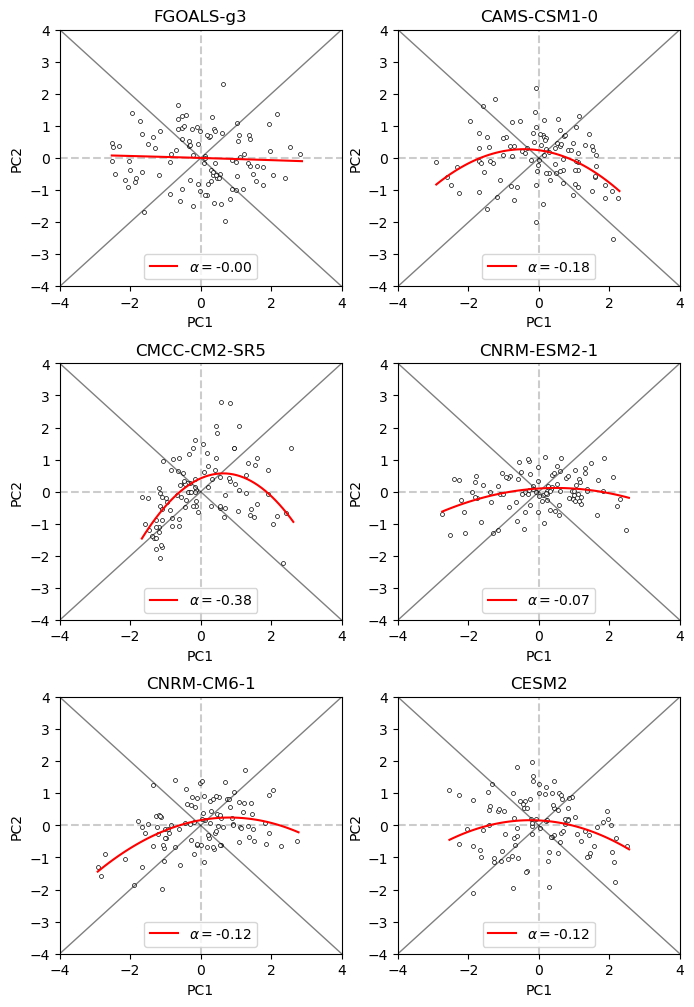

In [9]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(8, 12))
axs = axs.ravel()
for num, (ds, (pc1, pc2, alpha, xfit, fit)) in enumerate(alpha_fits.items()):
    ax = axs[num]
    ax.axhline(0, color="k", linestyle="--", alpha=0.2)
    ax.axvline(0, color="k", linestyle="--", alpha=0.2)

    # draw a line 45 degrees
    x = np.linspace(-6, 6, 100)
    y = x
    ax.plot(x, y, color="k", alpha=0.5, lw=1)
    ax.plot(-x, y, color="k", alpha=0.5, lw=1)

    ax.scatter(
        pc1,
        pc2,
        s=8,
        marker="o",
        c="w",
        edgecolors="k",
        linewidths=0.5,
    )

    ax.plot(xfit, fit, c="r", label=f"$\\alpha=${alpha:.2f}")

    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")

    ax.set_title(ds.split(".")[3])

    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
    ax.legend()
fig.subplots_adjust(hspace=0.3)

From this example, we can see that from the subset of models we have selected, the `alpha` parameter is higher for CMCC-CM2-SR5 compared to the other models as the "boomerang" shape is better represented in this model. This indicates that this model is better at representing extreme ENSO events compared to the other models.

## Summary
In this notebook, we used intake-esgf with Rooki Python client to retrieve a subset of a CMIP6 dataset. The subset and regrid operations are executed remotely on a Rook subsetting service (using OGC API and xarray/clisops). The dataset is analyzed using xeofs to extract a measurement used in ENSO research. We also showed that remote operators can be chained to be executed in a single workflow operation.

### What's next?

This service is used by the European Copernicus Climate Data Store. 

We need to figure out how this service can be used in the new ESGF: 
* where will it be deployed? 
* how can it be integrated in the ESGF search (STAC catalogs, ...)
* ???

## Resources
- [Roocs on GitHub](https://github.com/roocs)
- [Copernicus Climate Data Store](https://cds.climate.copernicus.eu/)
- [STAC](https://stacspec.org/en)

## References
- Cai, W., Santoso, A., Collins, M., Dewitte, B., Karamperidou, C., Kug, J.-S., Lengaigne, M., McPhaden, M. J., Stuecker, M. F., Taschetto, A. S., Timmermann, A., Wu, L., Yeh, S.-W., Wang, G., Ng, B., Jia, F., Yang, Y., Ying, J., Zheng, X.-T., … Zhong, W. (2021). Changing El Niño–Southern Oscillation in a warming climate. Nature Reviews Earth & Environment, 2(9), 628–644. https://doi.org/10.1038/s43017-021-00199-z
- Cai, W., Wang, G., Dewitte, B., Wu, L., Santoso, A., Takahashi, K., Yang, Y., Carréric, A., & McPhaden, M. J. (2018). Increased variability of eastern Pacific El Niño under greenhouse warming. Nature, 564(7735), 201–206. https://doi.org/10.1038/s41586-018-0776-9
- Karamperidou, C., Jin, F.-F., & Conroy, J. L. (2017). The importance of ENSO nonlinearities in tropical pacific response to external forcing. Climate Dynamics, 49(7), 2695–2704. https://doi.org/10.1007/s00382-016-3475-y
- Takahashi, K., Montecinos, A., Goubanova, K., & Dewitte, B. (2011). ENSO regimes: Reinterpreting the canonical and Modoki El Niño. Geophysical Research Letters, 38(10). https://doi.org/10.1029/2011GL047364
